# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import ttest_ind
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [4]:
medical.shape

(1338, 8)

In [5]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A: From the histogram, we can tell that the distribution is skewed to the right. From the statistics tho, we can see that the standard deviation of the sample is really high.__

The mean charge is $13270.42, and the standard deviation of the sample is 12105.484975561605. 


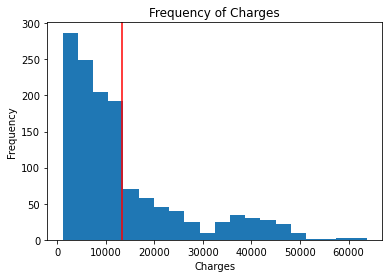

In [36]:
mean = np.mean(medical['charges'])
std = np.std(medical['charges'])

print('The mean charge is $' + str("{:.2f}".format(mean)) +", and the standard deviation of the sample is " + str(std) + ". ")

_ = medical.hist('charges', bins=20, grid=False)
_ = plt.xlabel('Charges')
_ = plt.ylabel('Frequency')
_ = plt.title('Frequency of Charges')
_ = plt.axvline(mean, c='red')
plt.show()

In [35]:
mean = np.mean(medical['charges'])
std = np.std(medical['charges'])

print(mean, std)

13270.422265141257 12105.484975561605


__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A: Right now, there seems to be no justification for the mean or the statement that the average has dropped below 12000, since the standard deviation of the sample is too high. What we can do is to resample multiple times or bootstrap to get the means of more samples and compare them together.__

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A: Since we are just comparing whether the actual mean is below 12000 or not, we can use a one sided interval with 95% confidence interval.__

In [39]:
def bootstrap_sampler(n):
    return np.random.choice(medical['charges'], n)

In [50]:
#We draw a certain number of people from our sample, and we calculate and compare the means of those samples. The number
# we are drawing from the sample is the square root of the number of the people in the sample.
seed(47)

a1 = bootstrap_sampler(int(np.sqrt(medical.shape[0])))
np.mean(a1)

12981.536660555555

__From drawing sample with a size of roughly 36 from our sample, we can see that we got a new mean already. We should repeat this process 50000 times as a bootstrapping process.__

In [58]:
seed(48)
means_bootstrap = np.array([np.mean(bootstrap_sampler(int(np.sqrt(medical.shape[0])))) for i in range(50000)])

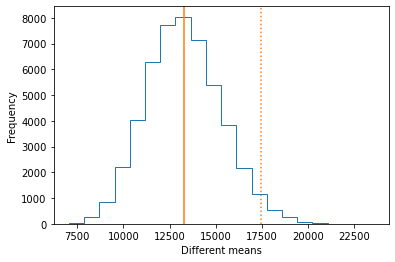

In [111]:
mean_of_bootstrap = np.mean(means_bootstrap)
df = pd.DataFrame(means_bootstrap)
std_of_dis = np.std(means_bootstrap)/(int(np.sqrt(medical.shape[0])))
#Now we have an array with size 50000 of means from bootstrapping from the sample

_ = plt.hist(means_bootstrap, bins=20, histtype='step')
_ = plt.xlabel('Different means')
_ = plt.ylabel('Frequency')
_ = plt.axvline(mean_of_bootstrap, c='C1')
_ = plt.axvline(df.iloc[:, 0].quantile(0.975), c='C1', linestyle=':')


In [105]:
print("The standard deviation of the distribution is " + str(std_of_dis))
print("Moreover, the distribution is starting to look like a normal distribution.")

The standard deviation of the distribution is 55.890159628844806
Moreover, the distribution is starting to look like a normal distribution.


In [114]:
#Since we are using the 95% confidence interval, we can use the z score 1.96
upper = mean_of_bootstrap + 1.96 * std_of_dis
lower = mean_of_bootstrap - 1.96 * std_of_dis

print(upper, lower)
print("With a 95% confidence interval, we can say that the mean of the charges is between 13378 and 13159, which means that there is no worries that the avergae has dropped below 12000.")

13378.178653317744 13159.089227572673
With a 95% confidence interval, we can say that the mean of the charges is between 13378 and 13159, which means that there is no worries that the avergae has dropped below 12000.


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A: We are making the null hypothesis that people with insurance gets charged the same as the people without insurance. The alternative hypothesis would be that people with insurance gets charged differently than the ones without insurace. In this scenario, we are assuming the variance of both groups to be the same.__

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [122]:
ins = medical[medical.insuranceclaim==1]['charges']
nins = medical[medical.insuranceclaim==0]['charges']

In [148]:
s0 = np.std(ins, ddof=1)
s1 = np.std(nins, ddof=1)

x0 = np.mean(ins)
x1 = np.mean(nins)

n0 = ins.shape[0]
n1 = nins.shape[0]

sp = np.sqrt(((n0 - 1) * (s0 ** 2) + (n1 - 1) * (s1 ** 2))/(n0 + n1 -2))
ts = (x0 - x1)/(sp * np.sqrt(1/n0 + 1/n1))
print('The pooled standard deviation is ' + str(sp) + '.')
print('The t-value is '+ str(ts))
print("The corresponding p value is " + str(t.sf(ts, df=n0+n1-2)))

The pooled standard deviation is 11520.034268775256.
The t-value is 11.89329903087671
The corresponding p value is 2.230615115810486e-31


In [149]:
t0, p0 = ttest_ind(ins, nins)
print("The t-value is " + str(t0))
print("The p-value is " + str(p0))

The t-value is 11.893299030876712
The p-value is 4.461230231620717e-31


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A: Yes, if we do a two tailed z test with 95% confidence interval, we could get the similar thing.__

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test